In [1]:
import numpy as np
import math
from scipy.integrate import quad
from scipy.linalg import eigvalsh
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

In [2]:
#kronecker product code for more than 2 inputs
def kron(*matrices):
    result = np.array([[1]])
    for matrix in matrices:
        result = np.kron(result, matrix)
    return result

#Partial Trace Code
def IntegerDigits(n, b, l):
    digits = [0] * l
    pos = l - 1
    while pos != -1:
        digits[pos] = int(n % b)
        n //= b
        pos -= 1
    return digits

def FromDigits(digits, base):
    digits = digits[::-1]
    n = 0
    for i, d in enumerate(digits):
        n += d * base**i
        
    return n

def SwapParts(digits, p1, p2):
    new = np.copy(digits)
    new[p1] = digits[p2]
    new[p2] = digits[p1]
    return new

def dTraceSystem(D,s,dimen):
    Qudits=sorted(s)
    Qudits.reverse()
    TrkM = D
    z=len(Qudits)
    
    for q in range(z):
        n=math.log(TrkM.shape[0],dimen)
        assert n % 1 == 0
        n = int(n)
        
        M=TrkM
        M = np.array(M , dtype = complex)
        k=Qudits[q]
        temp = np.zeros(M.shape[0], dtype=complex)
        if k!=n:
            for j in range(n-k):
                b={0}
                for i in range(dimen**n):
                    digits=IntegerDigits(i,dimen,n)
                    if digits[n-1] != digits[n-j-2] and i not in  b:
                        number=FromDigits(
                            SwapParts(digits, n-1, n-j-2),
                            dimen
                        )
                        b.add(number)

                        temp[:] = M[i, :]
                        M[i, :] = M[number, :]
                        M[number, :] = temp

                        temp[:] = M[:, i]
                        M[:, i] = M[:, number]
                        M[:, number] = temp
        
        TrkM=[]
        for p in range(0,dimen**n,dimen):
            TrkM.append(
                sum(
                    M[p+h, h:dimen**n:dimen]
                    for h in range(dimen)
                )
            )
        TrkM = np.array(TrkM)
    
    return TrkM
#Recall matrix as dTraceSystem(matrix,[systems I want to trace out],dimension of system)


In [3]:
#defining basis vectors

#zero vector and its conjugate transpose                                         
zero= np.array([[1],[0]])
zeroCT=np.conjugate(zero.T)
#one vector and its conjugate transpose
one=np.array([[0],[1]])
oneCT=np.conjugate(one.T)
#plus vector and its conjugate transpose
plus=np.array([[1],[1]])*1/math.sqrt(2)
plusCT=np.conjugate(plus.T)
#minus vector and its conjugate transpose
minus=np.array([[1],[-1]])*1/math.sqrt(2)
minusCT=np.conjugate(minus.T)
#plusy and its conjugate transpose
plusy=np.array([[1],[complex(0.0, 1)]])*1/math.sqrt(2)
plusyCT=np.conjugate(plusy.T)
#minusy and its conjugate transpose
minusy=np.array([[1],[complex(0.0, -1)]])*1/math.sqrt(2)
minusyCT=np.conjugate(minusy.T)
#defining the Bell states
phiplus=(np.kron(zero, zero)+np.kron(one, one))*1/math.sqrt(2)
phiminus=(np.kron(zero, zero)-np.kron(one, one))*1/math.sqrt(2)
psiplus=(np.kron(zero, one)+np.kron(one, zero))*1/math.sqrt(2)
psiminus=(np.kron(zero, one)-np.kron(one, zero))*1/math.sqrt(2)
#defining the outer product of the Bell states
Phiplus=phiplus@np.conjugate(phiplus.T)
Phiminus=phiminus@np.conjugate(phiminus.T)
Psiplus=psiplus@np.conjugate(psiplus.T)
Psiminus=psiminus@np.conjugate(psiminus.T)
#defining Pauli matrices
pauliX=np.array([[0,1],[1,0]])
pauliY=np.array([[0,complex(0,-1)],[complex(0,1),0]])
pauliZ=np.array([[1,0],[0,-1]])

In [4]:
def r(p, q):
    return np.array([
        p[3]*q[0] + p[2]*q[1] + p[1]*q[2] + p[0]*q[3],
        p[2]*q[0] + p[3]*q[1] + p[0]*q[2] + p[1]*q[3],
        p[1]*q[0] + p[0]*q[1] + p[3]*q[2] + p[2]*q[3],
        p[0]*q[0] + p[1]*q[1] + p[2]*q[2] + p[3]*q[3]
    ])

def rNtimes(p, n):
    if n == 1:
        return r(p, p)
    else:
        return r(rNtimes(p, n-1), p)

In [5]:
#Defining parameters for GKP states

#Quality of GKP state
def sigmaloss(sigma , eta):
    return np.sqrt(eta*sigma**2 + (1-eta))

#Error functions
def f(x , mu , sigma , eta):
    s = sigmaloss(sigma , eta)
    return np.exp(-(x - mu)**2 / (2 * s**2))/(s * np.sqrt(2*np.pi))
def Pc(sigma , nu , eta):
    integrand = lambda x: f(x , 0 , sigma , eta)
    lower = -0.5 * np.sqrt(np.pi) + nu
    upper =  0.5 * np.sqrt(np.pi) - nu
    return quad(integrand, lower, upper)[0] 
    
def Pf(sigma , nu , eta):
    integrand = lambda x: f(x, 0, sigma, eta)
    lower = 0.5 * np.sqrt(np.pi) + nu
    upper = 1.5 * np.sqrt(np.pi) - nu
    return 2 * quad(integrand, lower, upper)[0]

#Bell state mixture probabilities
def p1(sigma , nu , eta):
    pc = Pc(sigma , nu , eta)
    pf = Pf(sigma , nu , eta)
    return (pc**2) / (pc + pf)**2
def p2(sigma , nu , eta):
    pc = Pc(sigma , nu , eta)
    pf = Pf(sigma , nu , eta)
    return (pc * pf) / (pc + pf)**2
def p3(sigma , nu , eta):
    pc = Pc(sigma , nu , eta)
    pf = Pf(sigma , nu , eta)
    return (pf**2) / (pc + pf)**2
#Mixture of Bell states
def new_vector(sigma , nu , eta):
    return np.array([
        p1(sigma , nu , eta) , 
        p2(sigma , nu , eta) , 
        p2(sigma , nu , eta) , 
        p3(sigma , nu , eta)
        ])

#von Neumann entropy
def vonneumann(mat):
    evals = eigvalsh(mat)
    evals = np.clip(evals, 1e-16 , 1)
    return -np.sum(evals * np.log2(evals))

# hashing bound
def hashing_bound(mat):
    sAB = vonneumann(mat)
    sA = vonneumann(dTraceSystem(mat , [2] , 2))
    sB = vonneumann(dTraceSystem(mat , [1] , 2))
    return max(sA - sAB , sB - sAB)

# chain function
def chain_function(vec , n):
    return rNtimes(vec , n)

# building the chain states
def BSM_mixture_chain(vec):
    return vec[0] * Phiplus + vec[1] * Phiminus + vec[2] * Psiplus + vec[3] * Psiminus
 

In [6]:
#GKP chains

# hashing rate
def hashing_rate(sigma , nu , eta , n):
    pc = Pc(sigma , nu , eta)
    pf = Pf(sigma , nu , eta)
    vec = chain_function(new_vector(sigma , nu , eta) , n)
    return (pc + pf)**(2*n) * hashing_bound(BSM_mixture_chain(vec))

# optimal hashing rate
def optimal_hashing_rate(sigma , eta , n , return_nu = False):
    def neg_rate(nu):
        try:
            value = hashing_rate(sigma , nu , eta , n)
            return -value if value > 0 else np.inf
        except Exception:
            return np.inf

    result = minimize_scalar(neg_rate, bounds=(0, 0.5 * np.sqrt(np.pi)), method='bounded')
    rate = -result.fun

    if not np.isfinite(rate) or rate <= 0:
        rate = 0.0

    if return_nu:
        return rate , result.x  # return rate, ν
    return rate

In [ ]:
# Single Rail

def SingleRailState(eta , gamma , Pd , Vis):
    return 2 * np.array(
        [
            [(1 - Pd)*Pd*gamma**2, 0 , 0 , 0], 
            [0 , (1 - Pd) * Pd * (1 - gamma) * gamma * (1 - np.sqrt(eta)) + 1/2 * ((1 - Pd)**2) * (1 - gamma) * gamma * np.sqrt(eta) , 1/2 * ((1 - Pd)**2) * (1 - gamma) * gamma * np.sqrt(eta)* Vis , 0] ,
            [0 , 1/2 * ((1 - Pd)**2) * (1 - gamma) * gamma * np.sqrt(eta) * Vis , (1 - Pd)* Pd * (1 - gamma) * gamma * (1 - np.sqrt(eta)) + 1/2 * ((1 - Pd)**2) * (1 - gamma) * gamma * np.sqrt(eta), 0] ,
            [0 , 0 , 0, (1 - Pd) * Pd * ((1 - gamma)**2) * ((1 - np.sqrt(eta))**2) + ((1 - Pd)**2) * ((1 - gamma)**2) * (1 - np.sqrt(eta)) * np.sqrt(eta)]
        ]
    )
# normalised quantum state for single-rail entangled memory pair
def QStateSingle(eta , gamma , Pd , Vis):
    state = SingleRailState(eta , gamma , Pd , Vis)
    tr = np.trace(state)
    # avoiding division by 0
    if tr == 0 or not np.isfinite(tr):
        return np.zeros_like(state)
    return state / tr

# Building chains of SR encoded states

def SRinitialState(eta , gamma):
    BSM = kron(np.identity(2) , Phiplus , np.identity(2))
    rho = kron(QStateSingle(eta , gamma , 0 , 1) , QStateSingle(eta , gamma , 0 , 1))
    rho = BSM @ rho @ np.conjugate(BSM.T)
    rho = rho / np.trace(rho)
    return dTraceSystem(rho , [2 , 3] , 2)

def SRextendState(rho , eta , gamma):
    BSM = kron(np.identity(2) , Phiplus , np.identity(2))
    rho_ext = kron(rho , QStateSingle(eta , gamma , 0 , 1))
    rho_ext = BSM @ rho_ext @ np.conjugate(BSM.T)
    rho_ext = rho_ext / np.trace(rho_ext)
    return dTraceSystem(rho_ext , [2 , 3] , 2)

def SRchainState(eta , gamma , n):
    if n == 1:
        return QStateSingle(eta , gamma , 0 , 1)
    rho = SRinitialState(eta , gamma)
    for _ in range(n - 2):
        rho = SRextendState(rho , eta , gamma)
    return rho

# Single-Rail Hashing Rate
def SRhashingrate(eta , gamma , n):
    PsuccSR = np.trace(SingleRailState(eta , gamma , 0 , 1))
    rho = SRchainState(eta , gamma , n)
    return (PsuccSR**n) * hashing_bound(rho)
# optimising over gamma
def optimal_SRhashingrate(eta , n):
    gammas = np.linspace(0, 1, 100)
    rates = []
    for gamma in gammas:
        try:
            rate = SRhashingrate(eta, gamma, n)
            # ensuring that the hashing rate is a valid number
            if not np.isnan(rate) and not np.isinf(rate):
                rates.append(rate)
        except Exception as e:
            # print(f"Skipping gamma = {gamma}: {e}")
            continue
    return max(rates) if rates else 0

In [8]:
# Dual Rail
def DualRailState(eta , Pd , Vis):
    return 4 * np.array(
        [
            [1/4 * ((1 - Pd)**2) * (Pd**2) * (1 - np.sqrt(eta))**2 + 1/4 * ((1 - Pd)**3) * Pd * (1 - np.sqrt(eta)) * np.sqrt(eta), 0 , 0 , 0] ,
            [0 , 1/4 * ((1 - Pd)**2) * (Pd**2) * (1 - np.sqrt(eta))**2 + 1/4 * ((1 - Pd)**3) * Pd * (1 - np.sqrt(eta)) * np.sqrt(eta) + 1/16 * ((1 - Pd)**4) * eta , 1/16 * ((1 - Pd)**4) * eta * Vis**2 , 0] ,
            [0 , 1/16 * ((1 - Pd)**4) *eta * Vis**2 , 1/4 * ((1 - Pd)**2) * (Pd**2) * (1 - np.sqrt(eta))**2 + 1/4 * ((1 - Pd)**3) * Pd * (1 - np.sqrt(eta)) * np.sqrt(eta) + 1/16 * ((1 - Pd)**4) * eta , 0] ,
            [0 , 0 , 0 , 1/4 * ((1 - Pd)**2) * (Pd**2) * (1 - np.sqrt(eta))**2 + 1/4 * ((1 - Pd)**3) * Pd * (1 - np.sqrt(eta)) * np.sqrt(eta)]
        ]
    )
# normalised quantum state for dual-rail entangled memory pair
def QStateDual(eta , Pd , Vis):
    state = DualRailState(eta , Pd , Vis)
    tr = np.trace(DualRailState(eta , Pd , Vis))
    # avoiding division by 0
    if tr == 0 or not np.isfinite(tr):
        return np.zeros_like(state)
    return state / tr

# hashing rate
def DRhashingrate(eta , n):
    PsuccDR = np.trace(DualRailState(eta , 0 , 1))

    if n == 1:
        return PsuccDR * hashing_bound(QStateDual(eta , 0 , 1))
    else:
        vec = rNtimes(np.linalg.eigvalsh(QStateDual(eta , 0 , 1)) , n - 1)
        rho = BSM_mixture_chain(vec)
        return (PsuccDR**n) * hashing_bound(rho)

/Users/conallcampbell/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2307: RuntimeWarning: invalid value encountered in scalar subtract
  p = (xf - fulc) * q - (xf - nfc) * r
/Users/conallcampbell/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:2308: RuntimeWarning: invalid value encountered in scalar subtract
  q = 2.0 * (q - r)


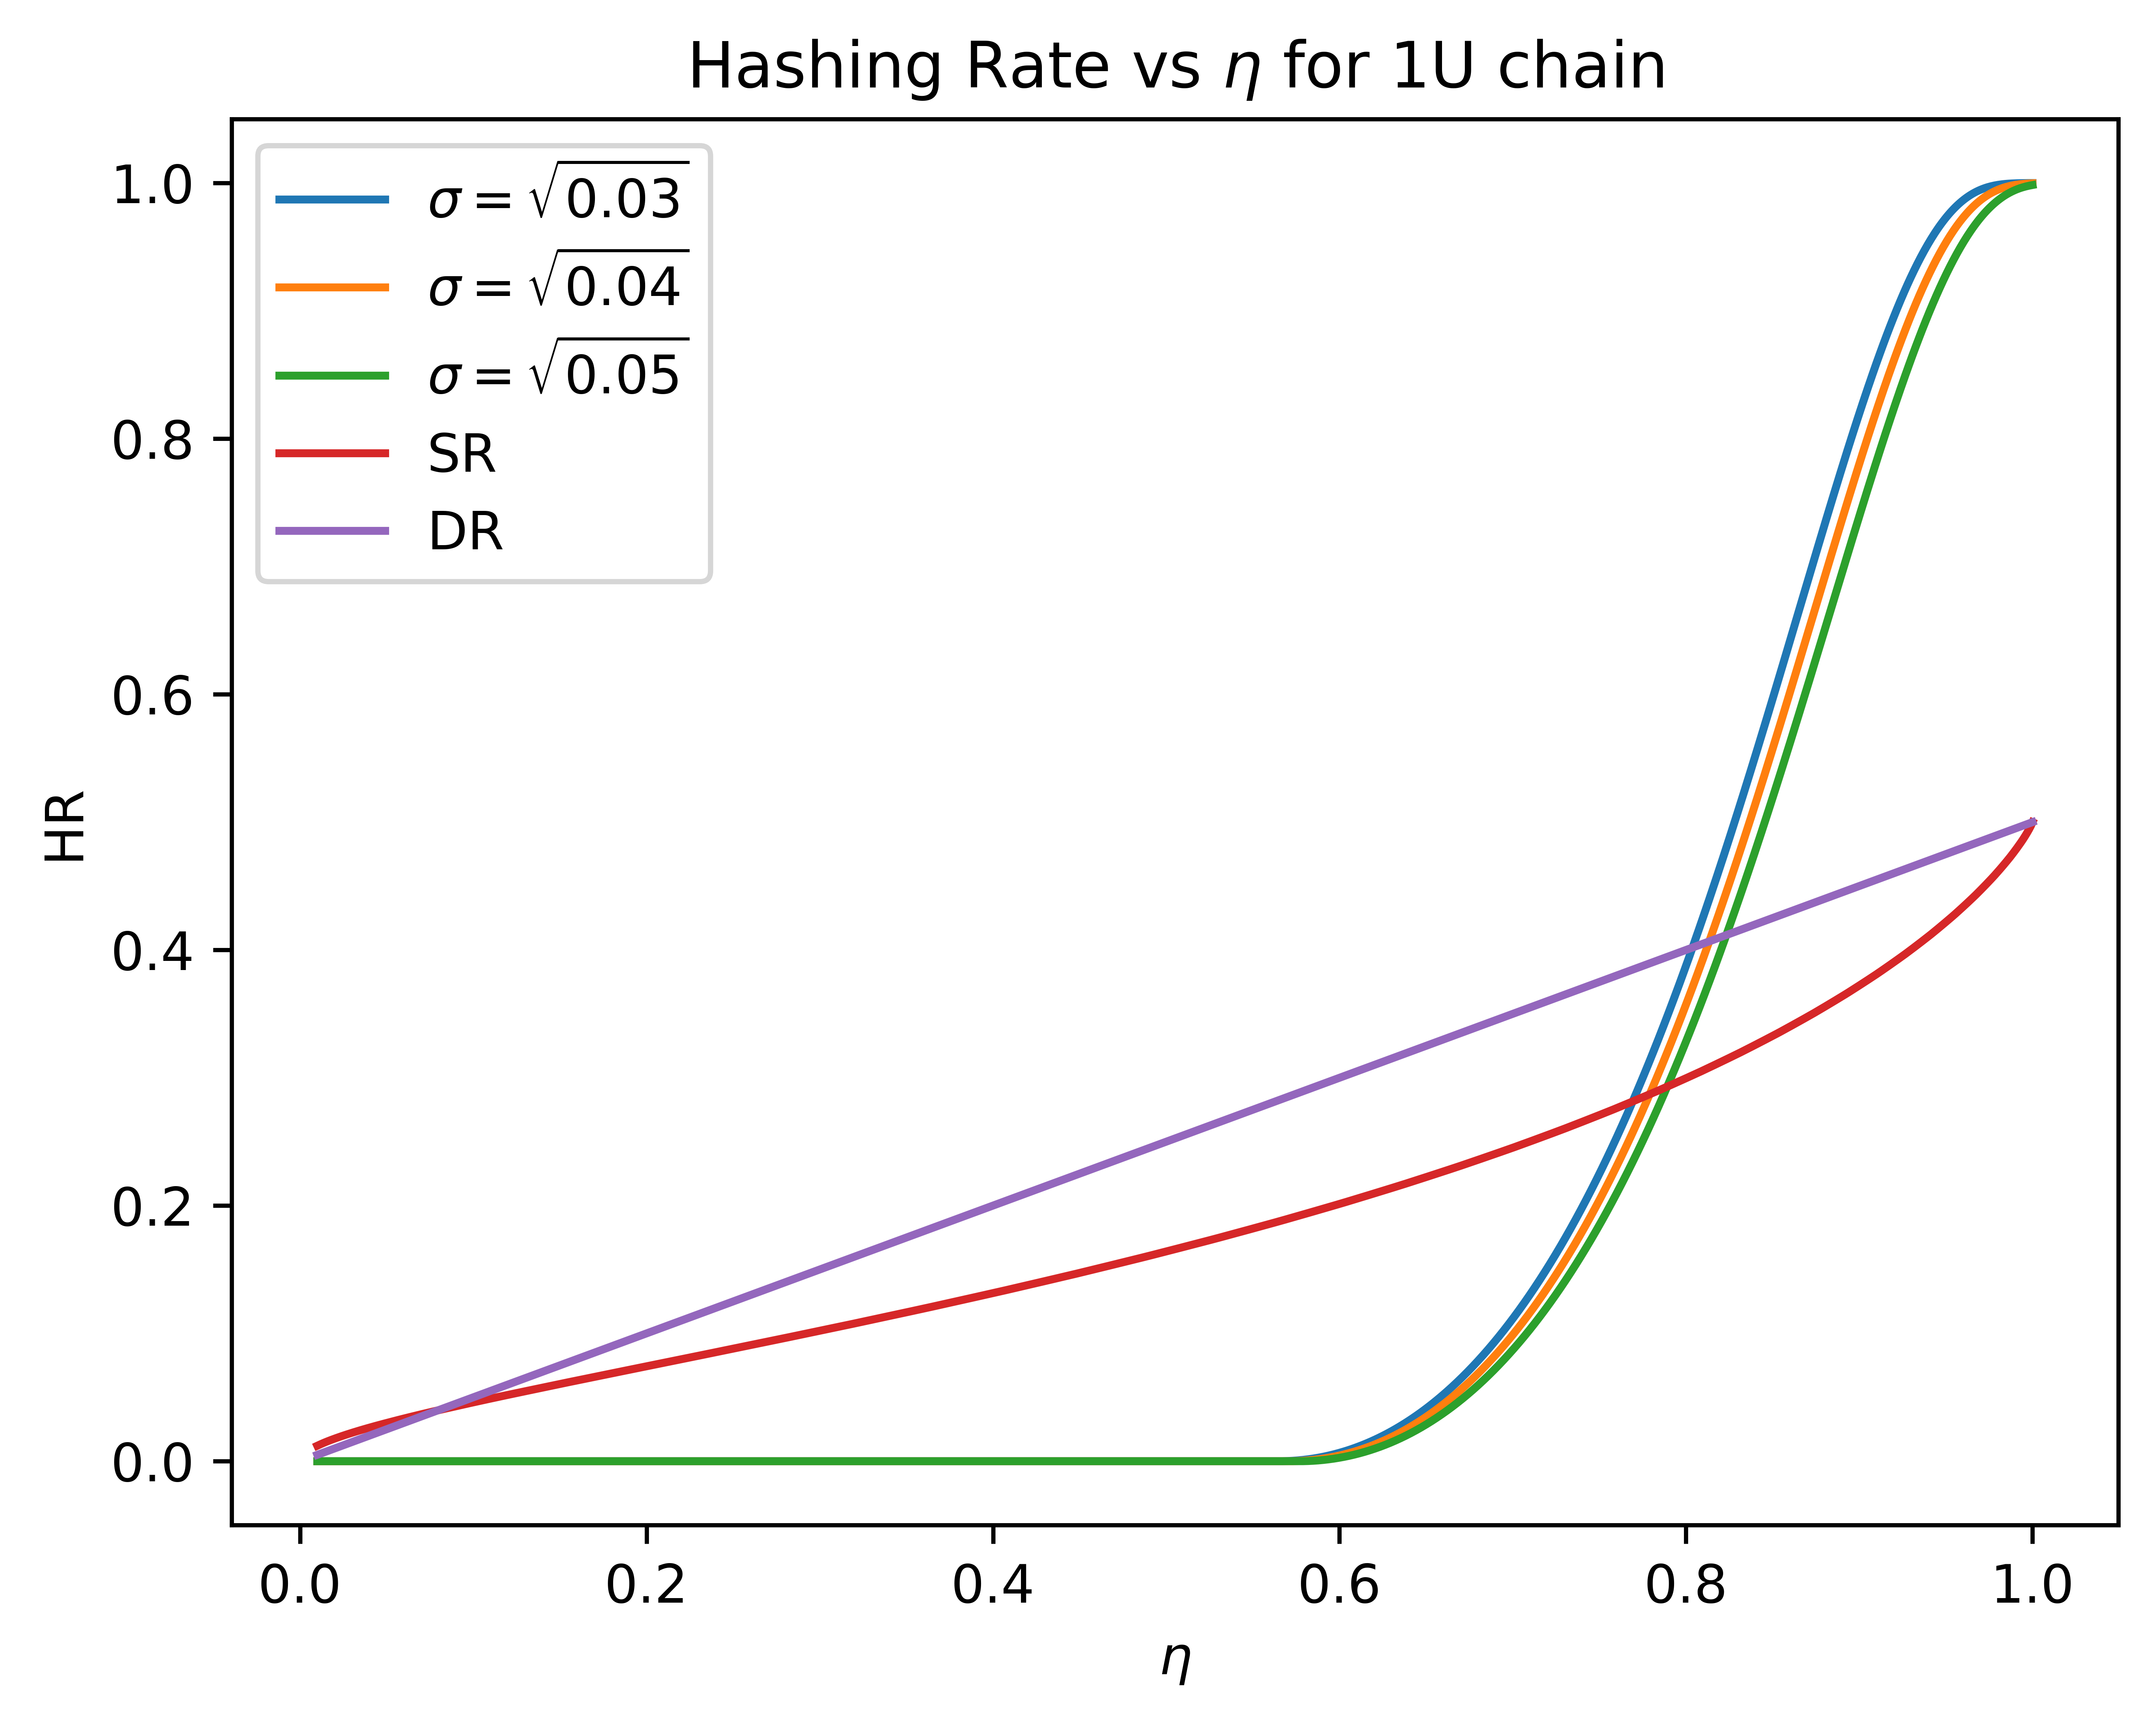

In [9]:
# Results

sigma1 = np.sqrt(0.03)
sigma2 = np.sqrt(0.04)
sigma3 = np.sqrt(0.05)

n = 1

etas = np.linspace(0.01 , 1.0 , 1000)

rates1 = [optimal_hashing_rate(sigma1 , eta , n) for eta in etas]
rates2 = [optimal_hashing_rate(sigma2 , eta , n) for eta in etas]
rates3 = [optimal_hashing_rate(sigma3 , eta , n) for eta in etas]

ratesSR = [optimal_SRhashingrate(eta , n) for eta in etas]
ratesDR = [DRhashingrate(eta , n) for eta in etas]


plt.figure(dpi = 1000)
plt.plot(etas , rates1 , label = r"$\sigma = \sqrt{0.03}$")
plt.plot(etas , rates2 , label = r"$\sigma = \sqrt{0.04}$")
plt.plot(etas , rates3 , label = r"$\sigma = \sqrt{0.05}$")
plt.plot(etas , ratesSR , label = r"SR")
plt.plot(etas , ratesDR , label = r"DR")
plt.xlabel("$\eta$")
plt.ylabel("HR")
plt.title(f"Hashing Rate vs $\eta$ for 1U chain")
plt.legend()
plt.show()

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_74163/1203300467.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


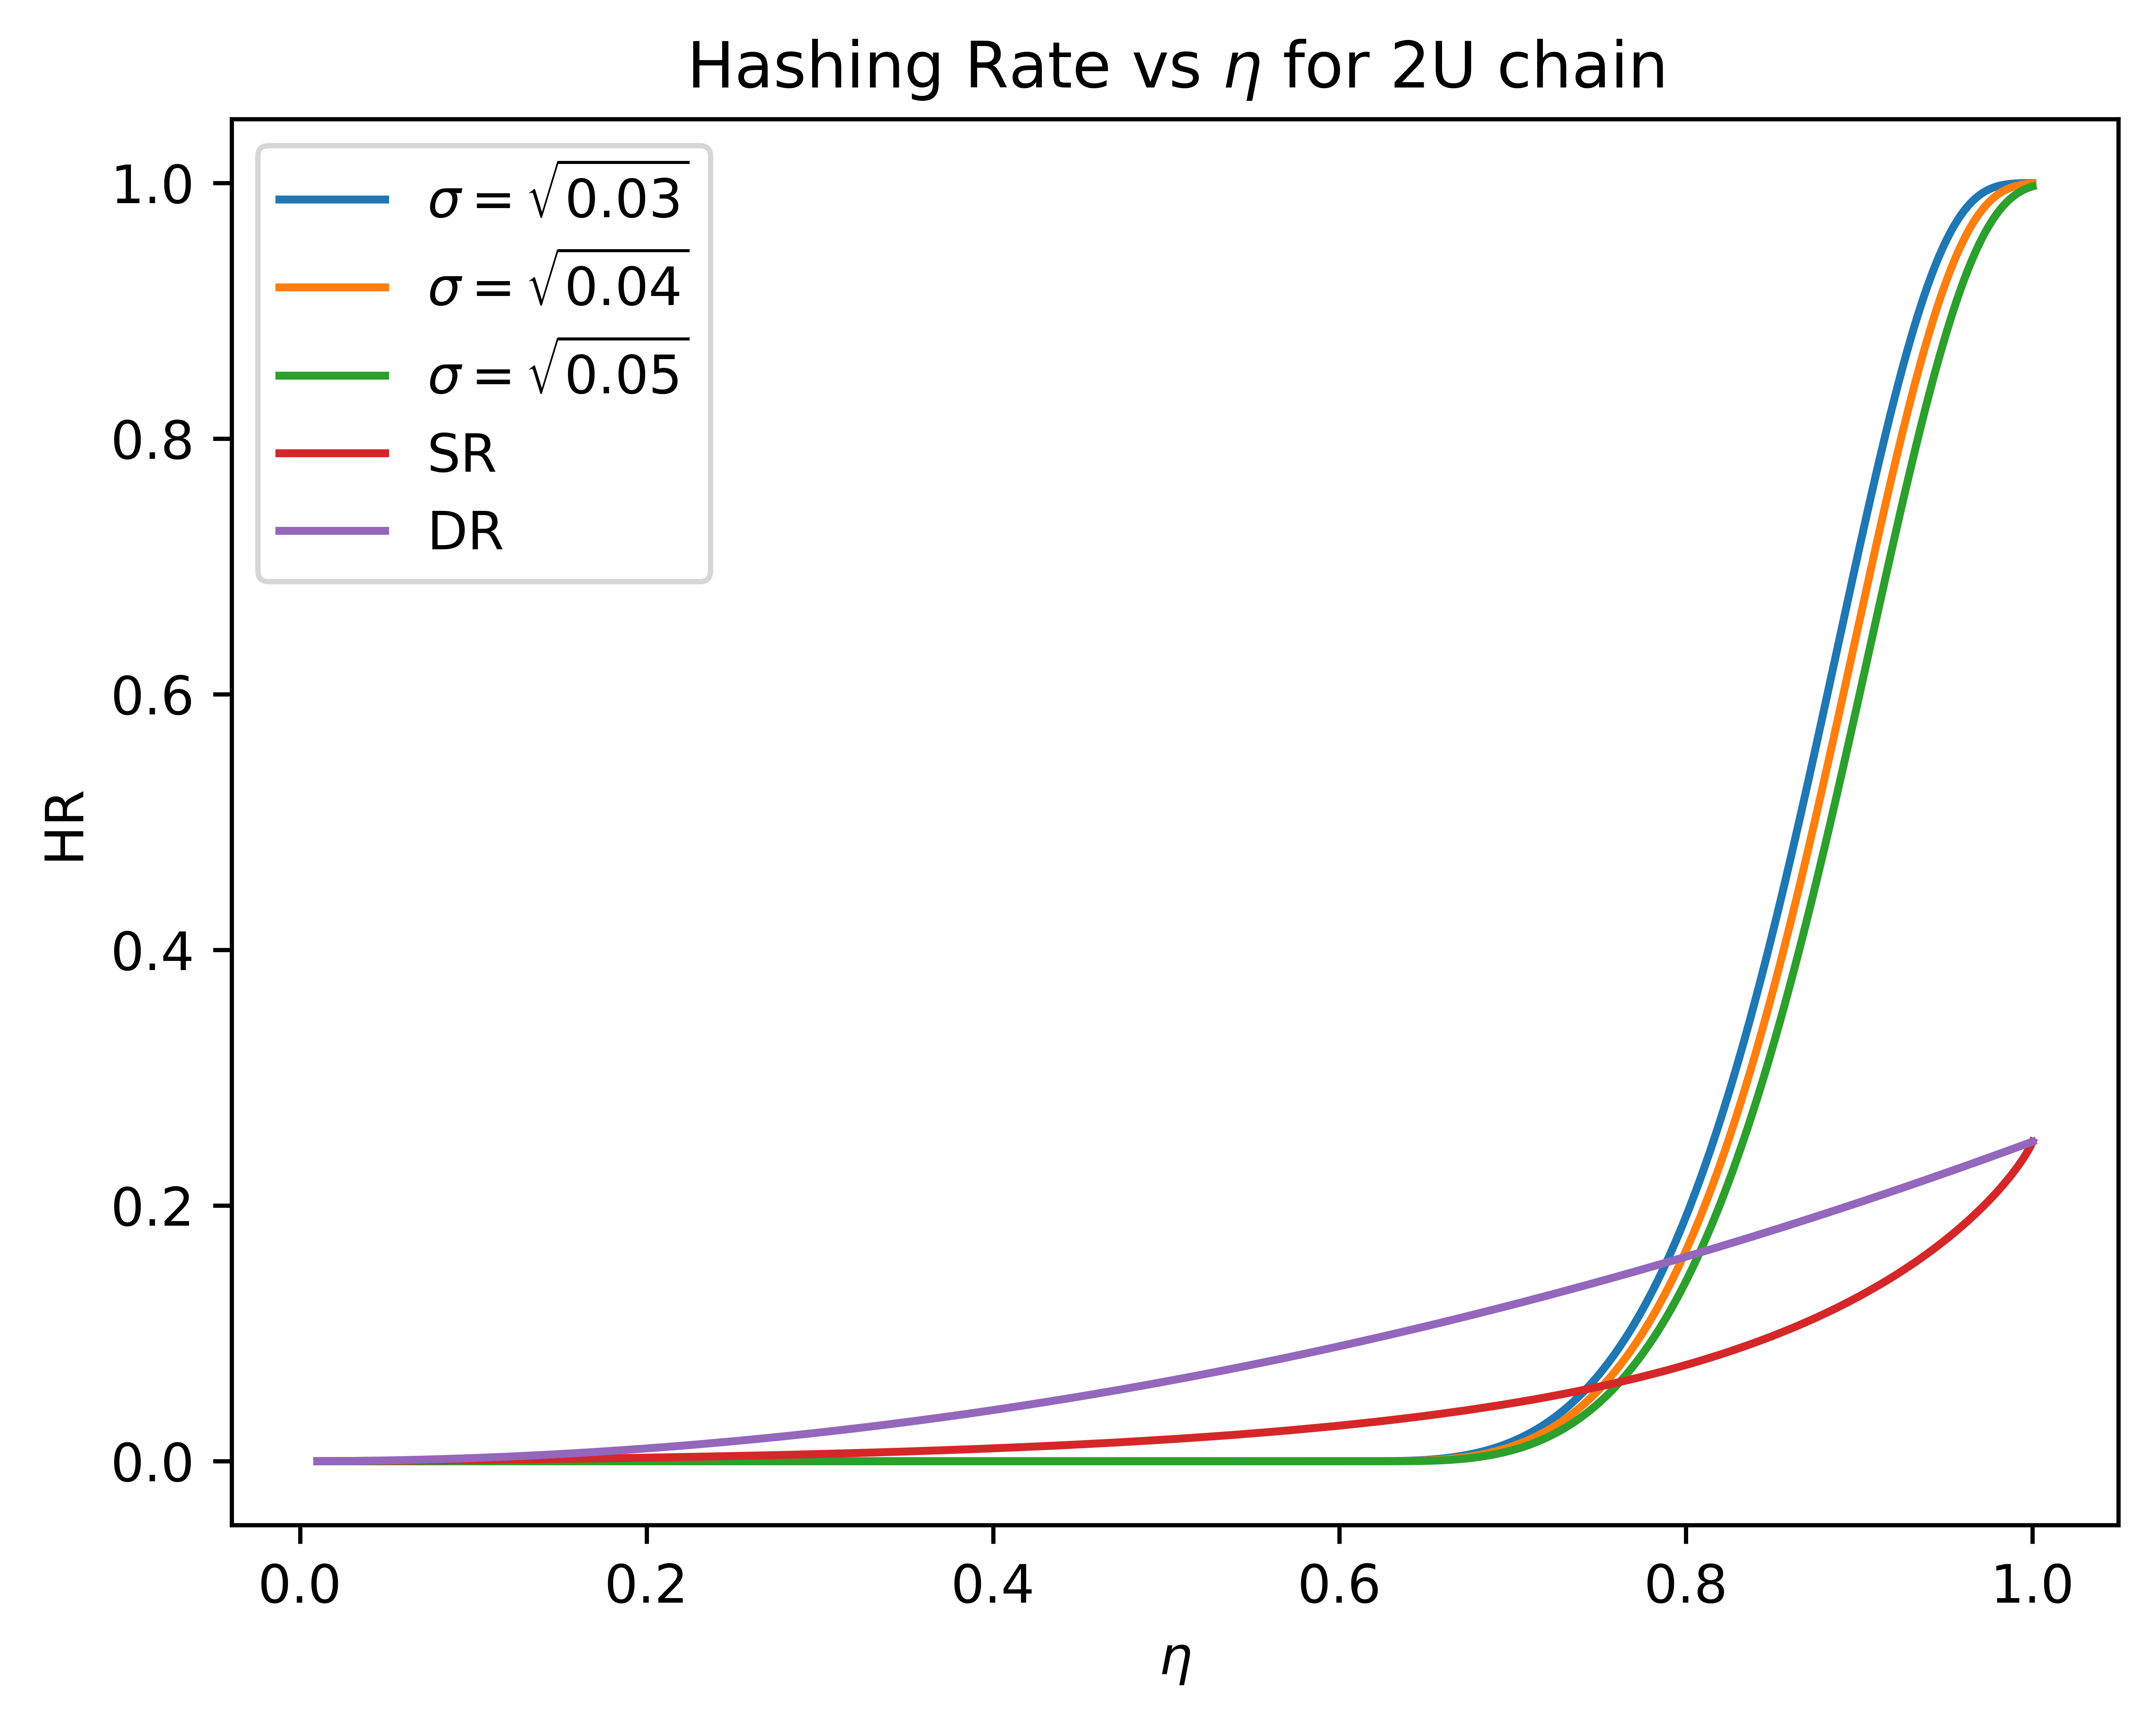

In [10]:
# Results

sigma1 = np.sqrt(0.03)
sigma2 = np.sqrt(0.04)
sigma3 = np.sqrt(0.05)

n = 2

etas = np.linspace(0.01 , 1.0 , 1000)

rates1 = [optimal_hashing_rate(sigma1 , eta , n) for eta in etas]
rates2 = [optimal_hashing_rate(sigma2 , eta , n) for eta in etas]
rates3 = [optimal_hashing_rate(sigma3 , eta , n) for eta in etas]

ratesSR = [optimal_SRhashingrate(eta , n) for eta in etas]
ratesDR = [DRhashingrate(eta , n) for eta in etas]


plt.figure(dpi = 1000)
plt.plot(etas , rates1 , label = r"$\sigma = \sqrt{0.03}$")
plt.plot(etas , rates2 , label = r"$\sigma = \sqrt{0.04}$")
plt.plot(etas , rates3 , label = r"$\sigma = \sqrt{0.05}$")
plt.plot(etas , ratesSR , label = r"SR")
plt.plot(etas , ratesDR , label = r"DR")
plt.xlabel("$\eta$")
plt.ylabel("HR")
plt.title(f"Hashing Rate vs $\eta$ for 2U chain")
plt.legend()
plt.show()

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_74163/1203300467.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


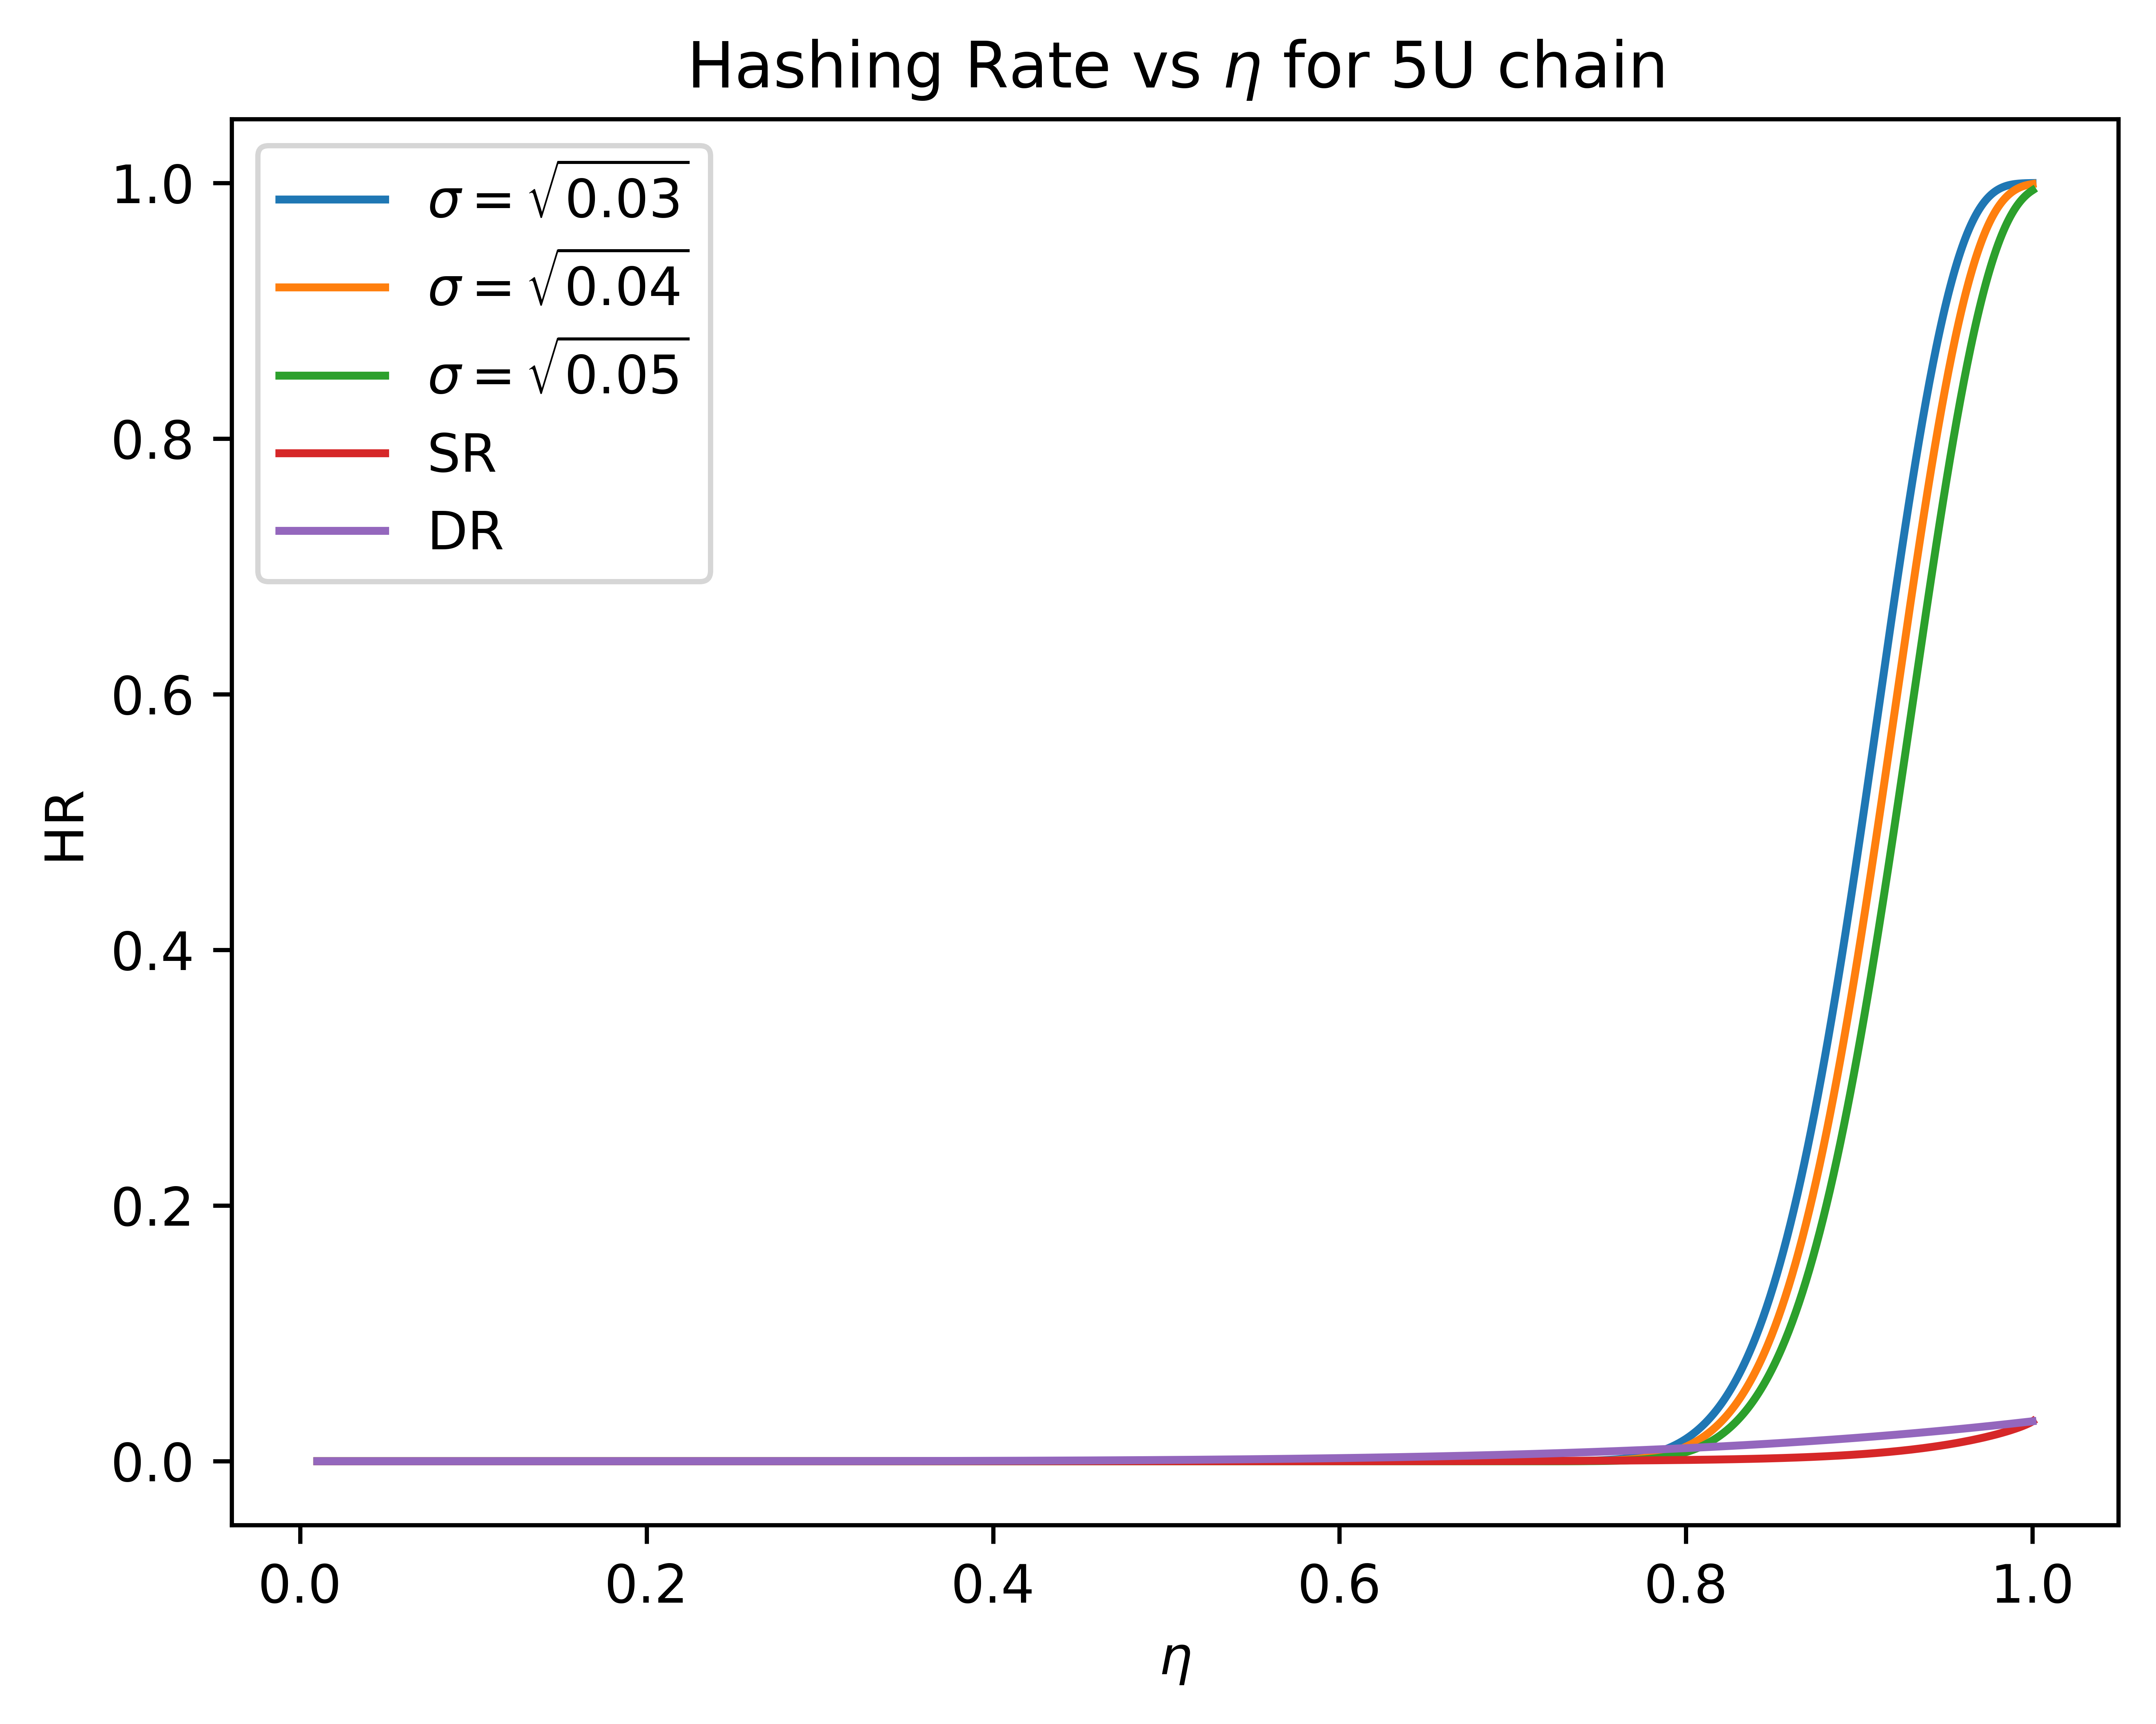

In [11]:
# Results

sigma1 = np.sqrt(0.03)
sigma2 = np.sqrt(0.04)
sigma3 = np.sqrt(0.05)

n = 5

etas = np.linspace(0.01 , 1.0 , 1000)

rates1 = [optimal_hashing_rate(sigma1 , eta , n) for eta in etas]
rates2 = [optimal_hashing_rate(sigma2 , eta , n) for eta in etas]
rates3 = [optimal_hashing_rate(sigma3 , eta , n) for eta in etas]

ratesSR = [optimal_SRhashingrate(eta , n) for eta in etas]
ratesDR = [DRhashingrate(eta , n) for eta in etas]


plt.figure(dpi = 1000)
plt.plot(etas , rates1 , label = r"$\sigma = \sqrt{0.03}$")
plt.plot(etas , rates2 , label = r"$\sigma = \sqrt{0.04}$")
plt.plot(etas , rates3 , label = r"$\sigma = \sqrt{0.05}$")
plt.plot(etas , ratesSR , label = r"SR")
plt.plot(etas , ratesDR , label = r"DR")
plt.xlabel("$\eta$")
plt.ylabel("HR")
plt.title(f"Hashing Rate vs $\eta$ for 5U chain")
plt.legend()
plt.show()

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_74163/1203300467.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


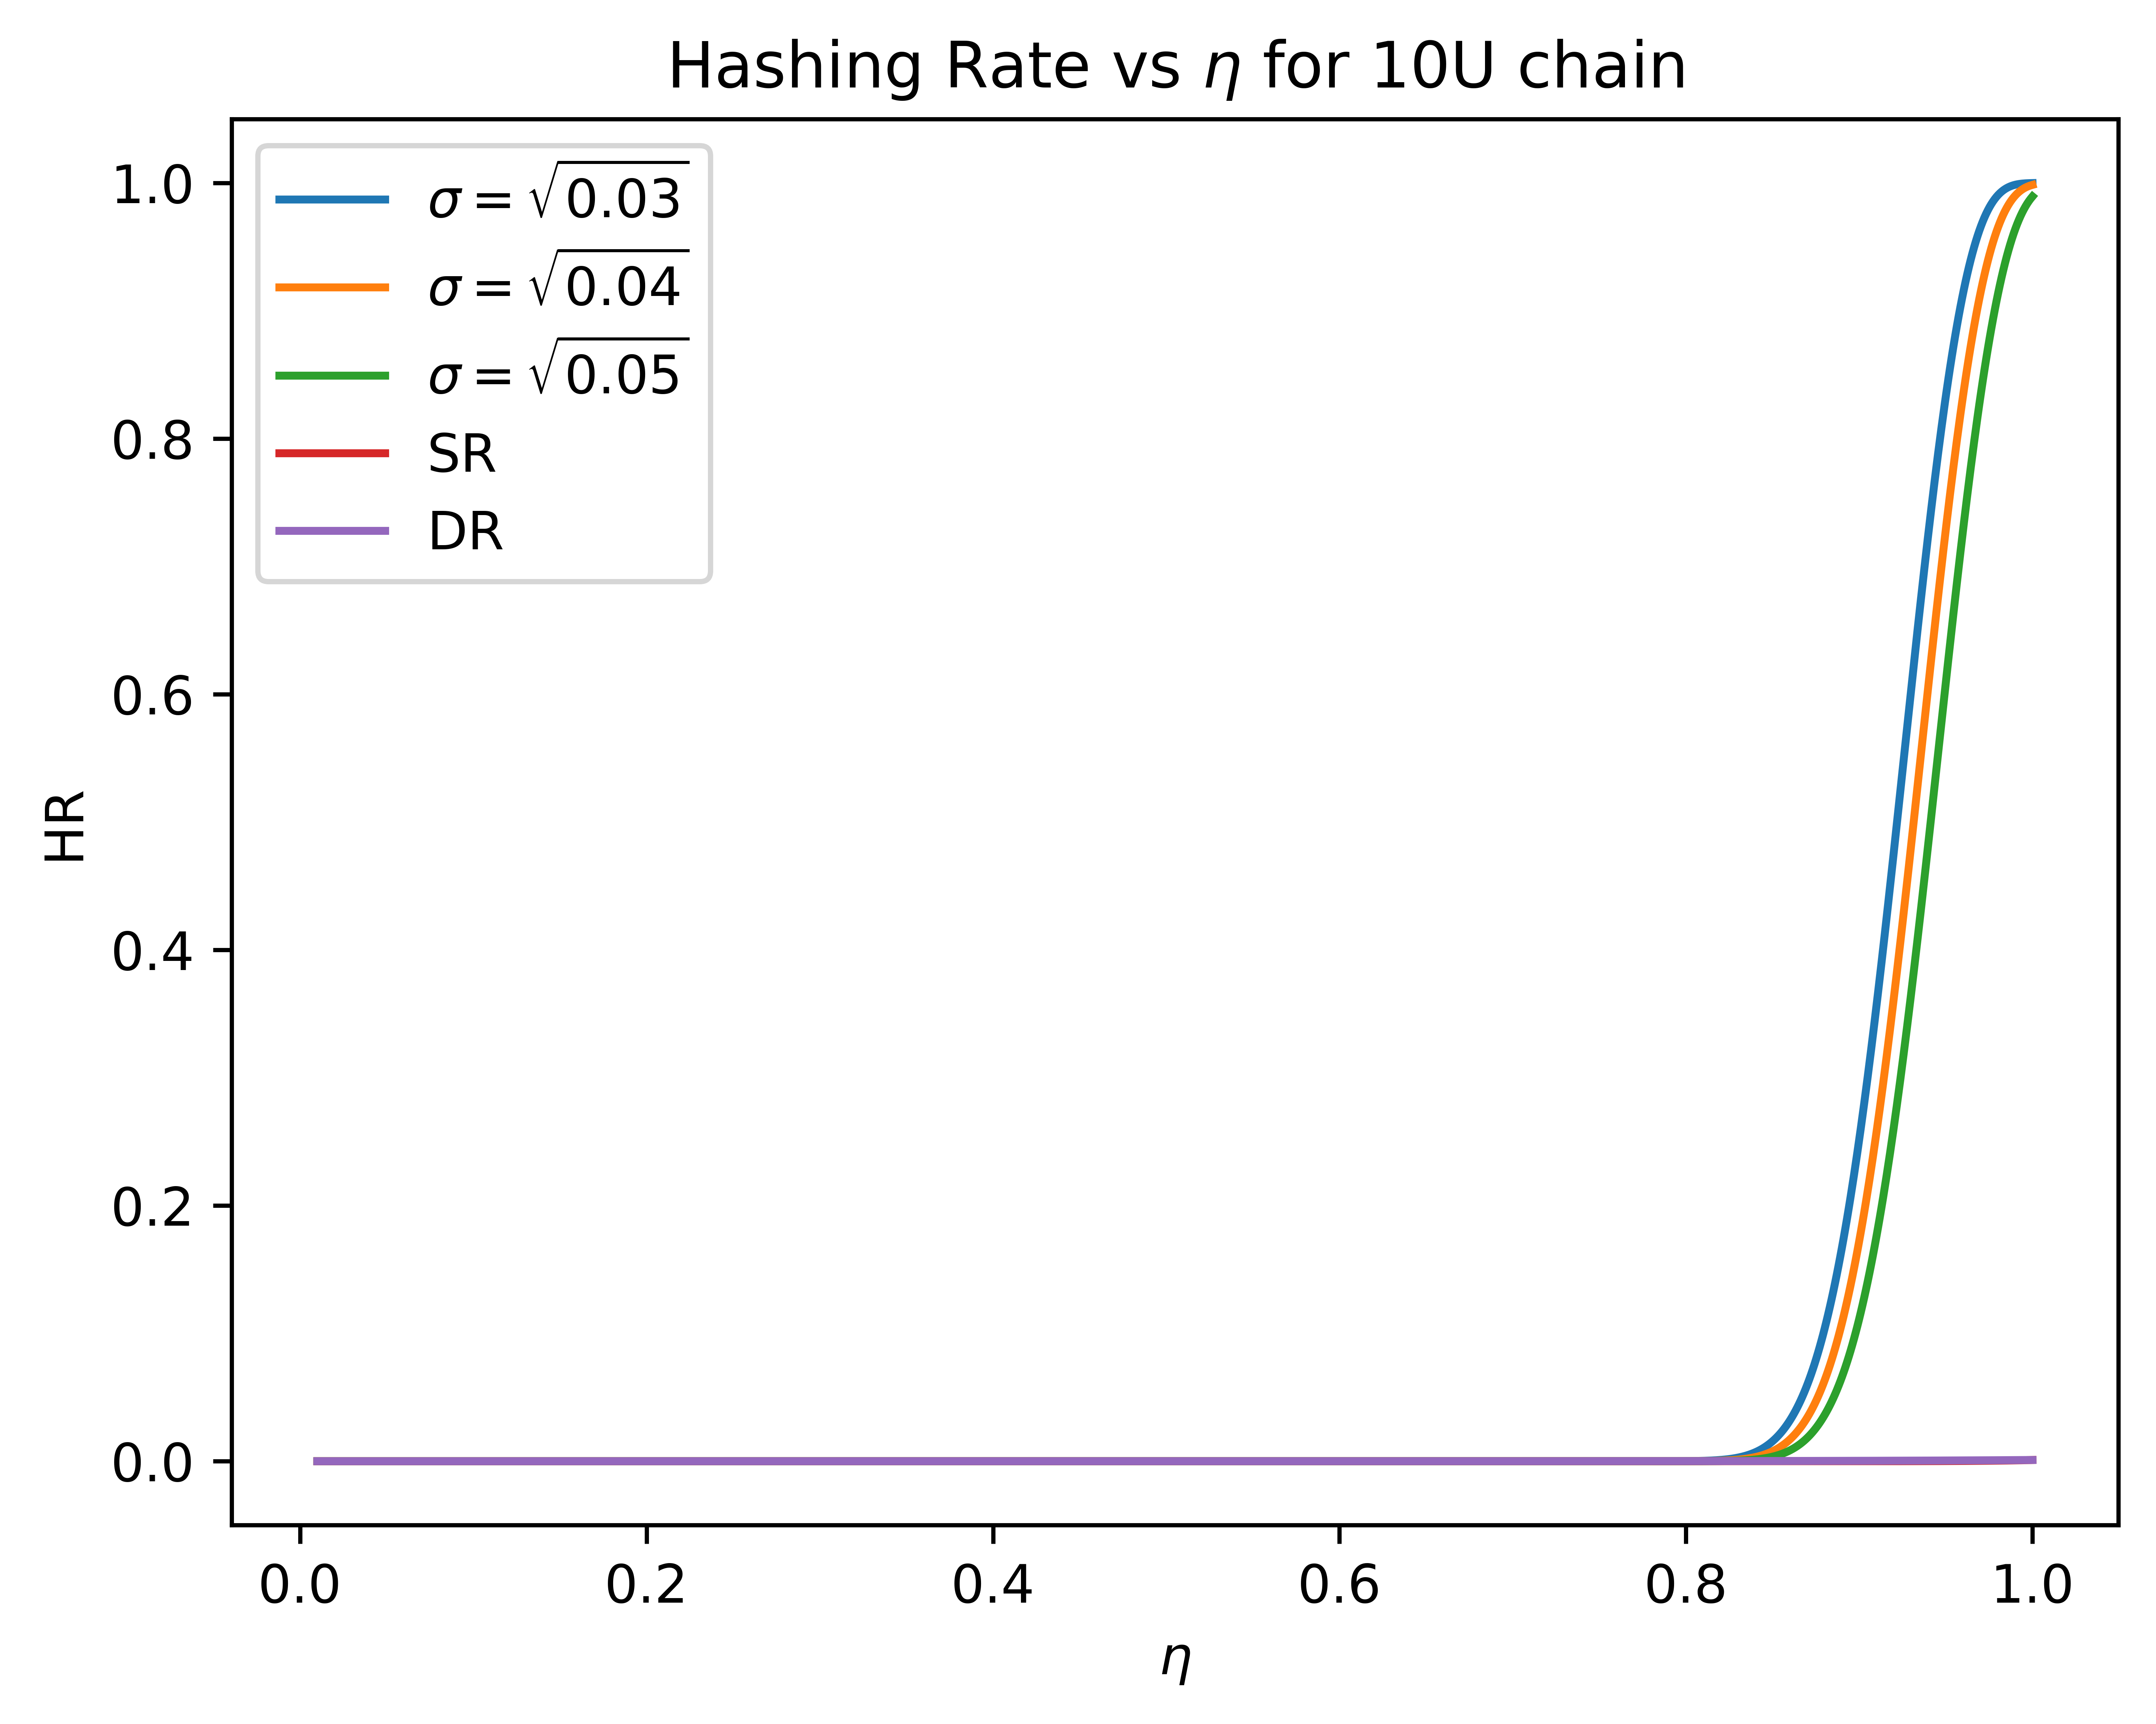

In [12]:
# Results

sigma1 = np.sqrt(0.03)
sigma2 = np.sqrt(0.04)
sigma3 = np.sqrt(0.05)

n = 10

etas = np.linspace(0.01 , 1.0 , 1000)

rates1 = [optimal_hashing_rate(sigma1 , eta , n) for eta in etas]
rates2 = [optimal_hashing_rate(sigma2 , eta , n) for eta in etas]
rates3 = [optimal_hashing_rate(sigma3 , eta , n) for eta in etas]

ratesSR = [optimal_SRhashingrate(eta , n) for eta in etas]
ratesDR = [DRhashingrate(eta , n) for eta in etas]


plt.figure(dpi = 1000)
plt.plot(etas , rates1 , label = r"$\sigma = \sqrt{0.03}$")
plt.plot(etas , rates2 , label = r"$\sigma = \sqrt{0.04}$")
plt.plot(etas , rates3 , label = r"$\sigma = \sqrt{0.05}$")
plt.plot(etas , ratesSR , label = r"SR")
plt.plot(etas , ratesDR , label = r"DR")
plt.xlabel("$\eta$")
plt.ylabel("HR")
plt.title(f"Hashing Rate vs $\eta$ for 10U chain")
plt.legend()
plt.show()

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_74163/1203300467.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


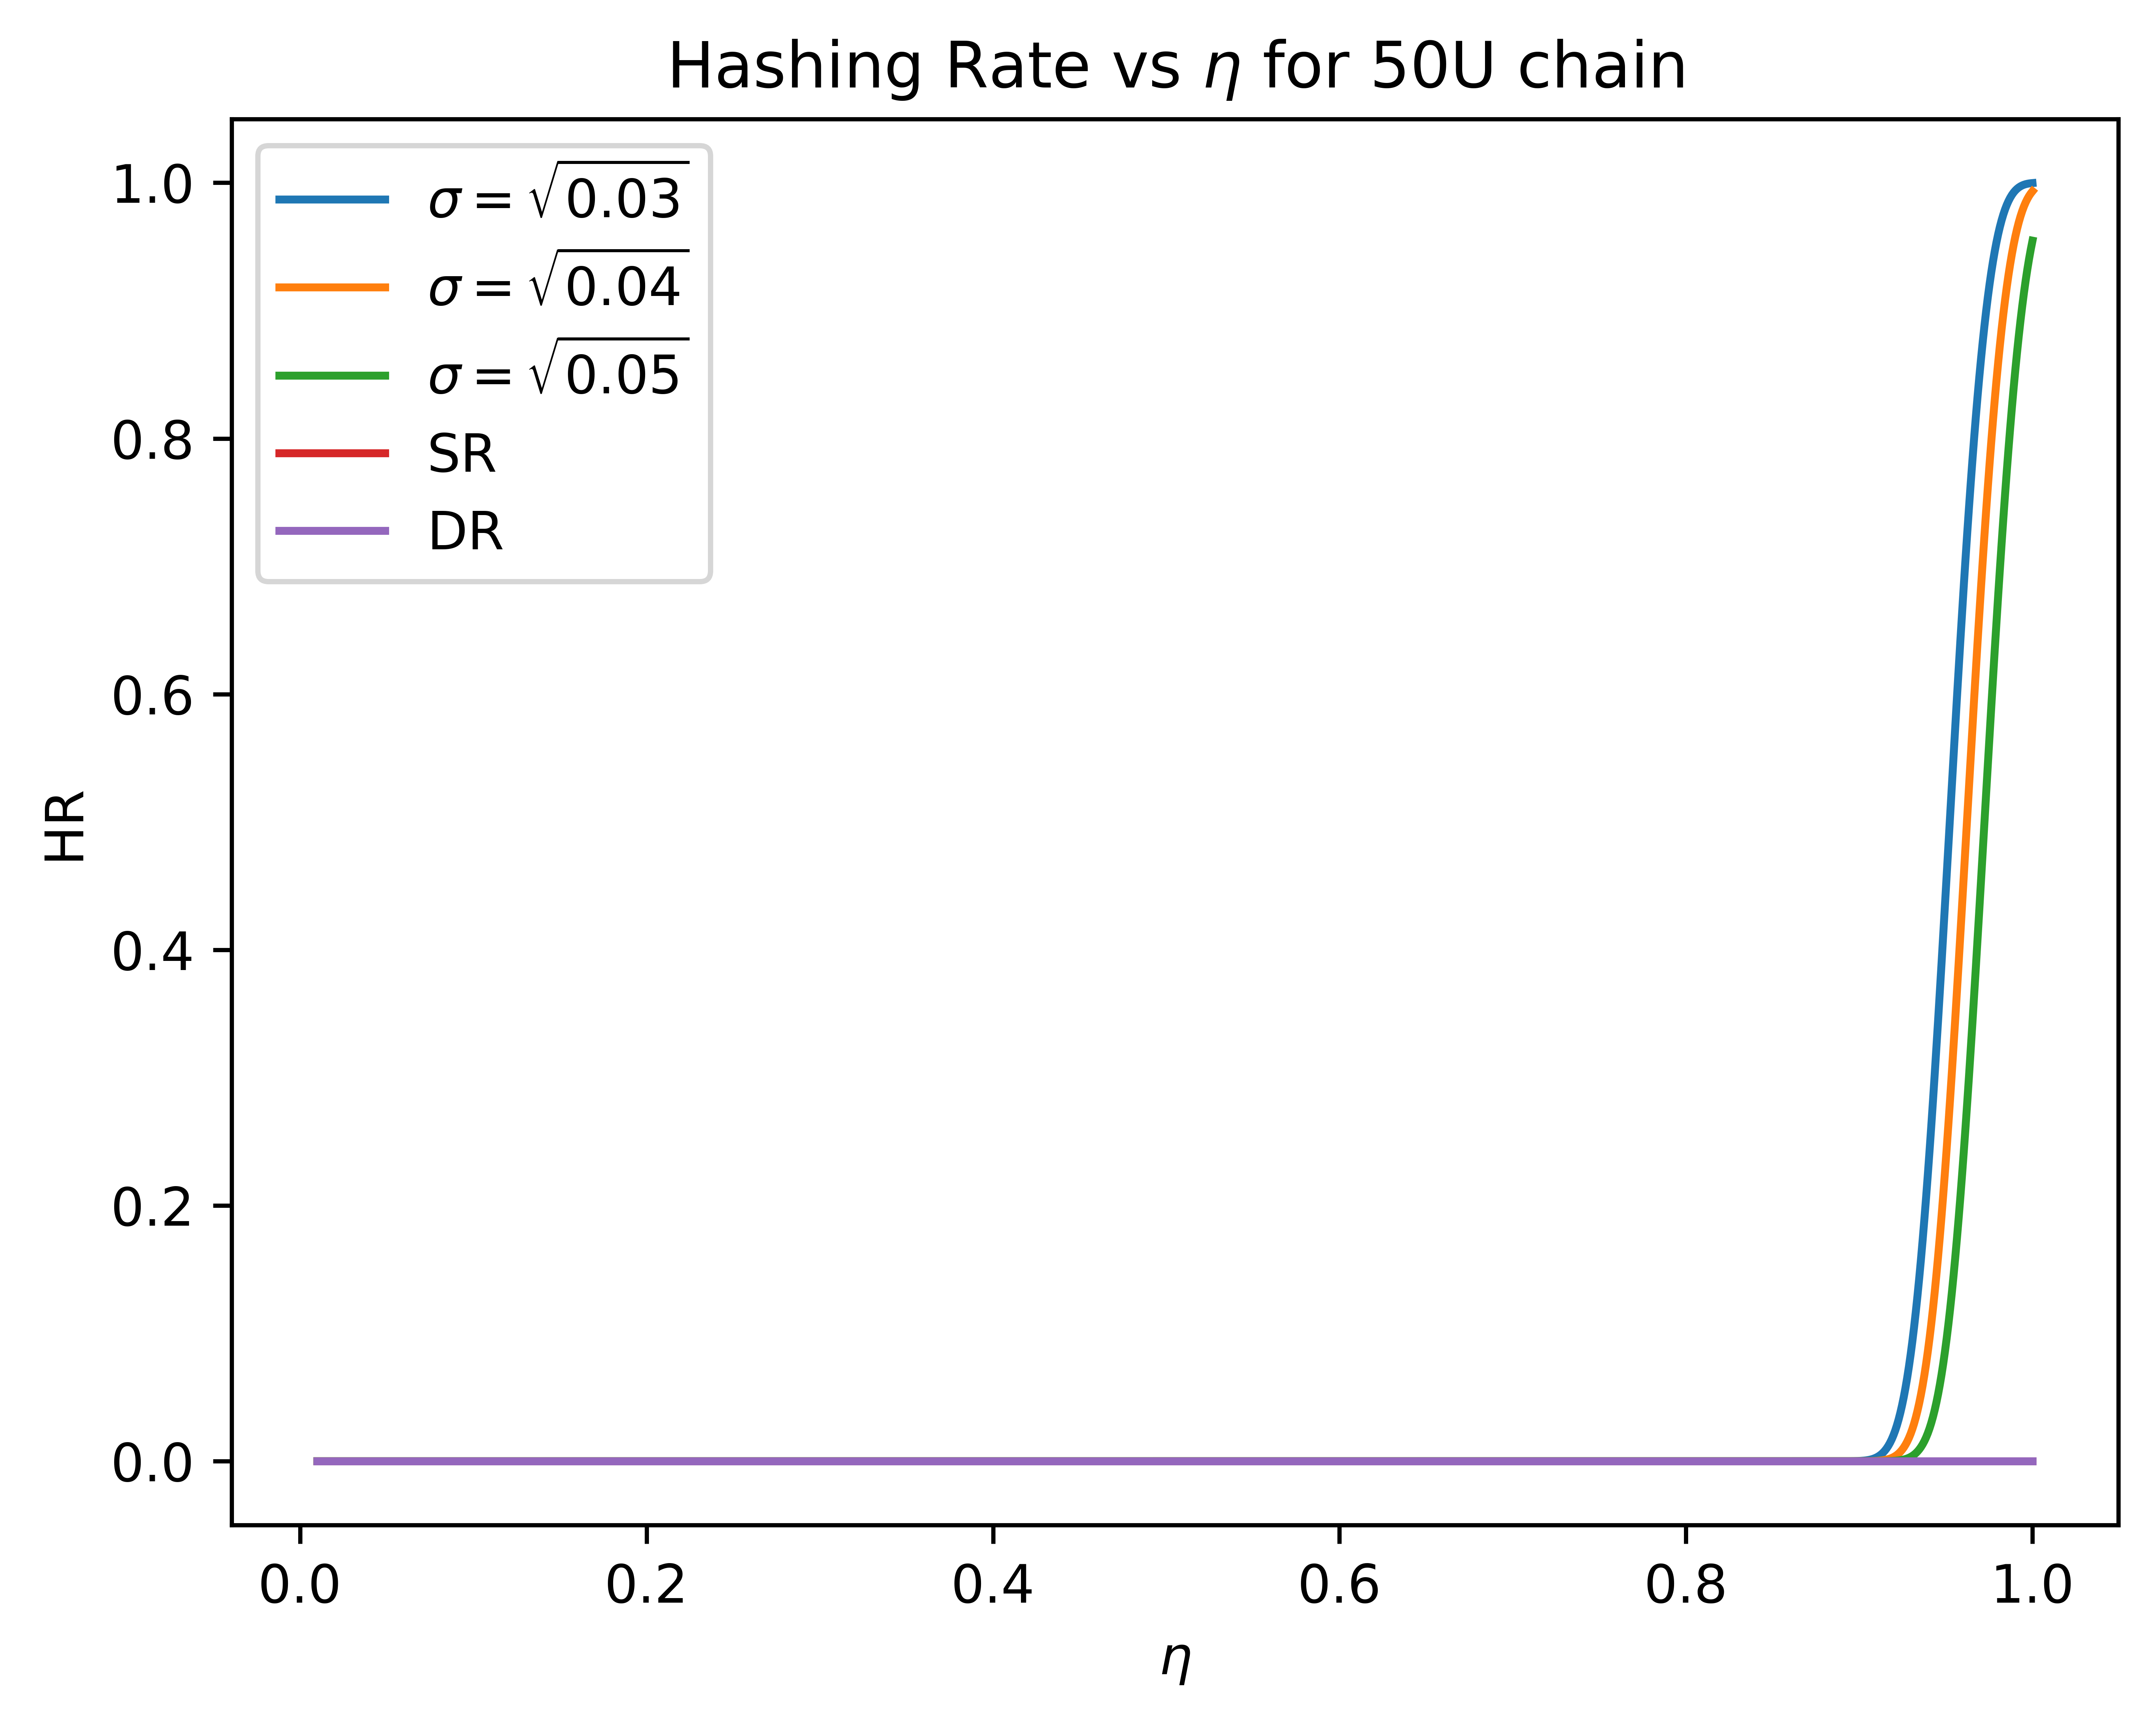

In [13]:
# Results

sigma1 = np.sqrt(0.03)
sigma2 = np.sqrt(0.04)
sigma3 = np.sqrt(0.05)

n = 50

etas = np.linspace(0.01 , 1.0 , 1000)

rates1 = [optimal_hashing_rate(sigma1 , eta , n) for eta in etas]
rates2 = [optimal_hashing_rate(sigma2 , eta , n) for eta in etas]
rates3 = [optimal_hashing_rate(sigma3 , eta , n) for eta in etas]

ratesSR = [optimal_SRhashingrate(eta , n) for eta in etas]
ratesDR = [DRhashingrate(eta , n) for eta in etas]


plt.figure(dpi = 1000)
plt.plot(etas , rates1 , label = r"$\sigma = \sqrt{0.03}$")
plt.plot(etas , rates2 , label = r"$\sigma = \sqrt{0.04}$")
plt.plot(etas , rates3 , label = r"$\sigma = \sqrt{0.05}$")
plt.plot(etas , ratesSR , label = r"SR")
plt.plot(etas , ratesDR , label = r"DR")
plt.xlabel("$\eta$")
plt.ylabel("HR")
plt.title(f"Hashing Rate vs $\eta$ for 50U chain")
plt.legend()
plt.show()

/var/folders/rk/pwmb5rhj2t7frz09r_j038xm0000gp/T/ipykernel_74163/1203300467.py:27: RuntimeWarning: invalid value encountered in divide
  rho = rho / np.trace(rho)


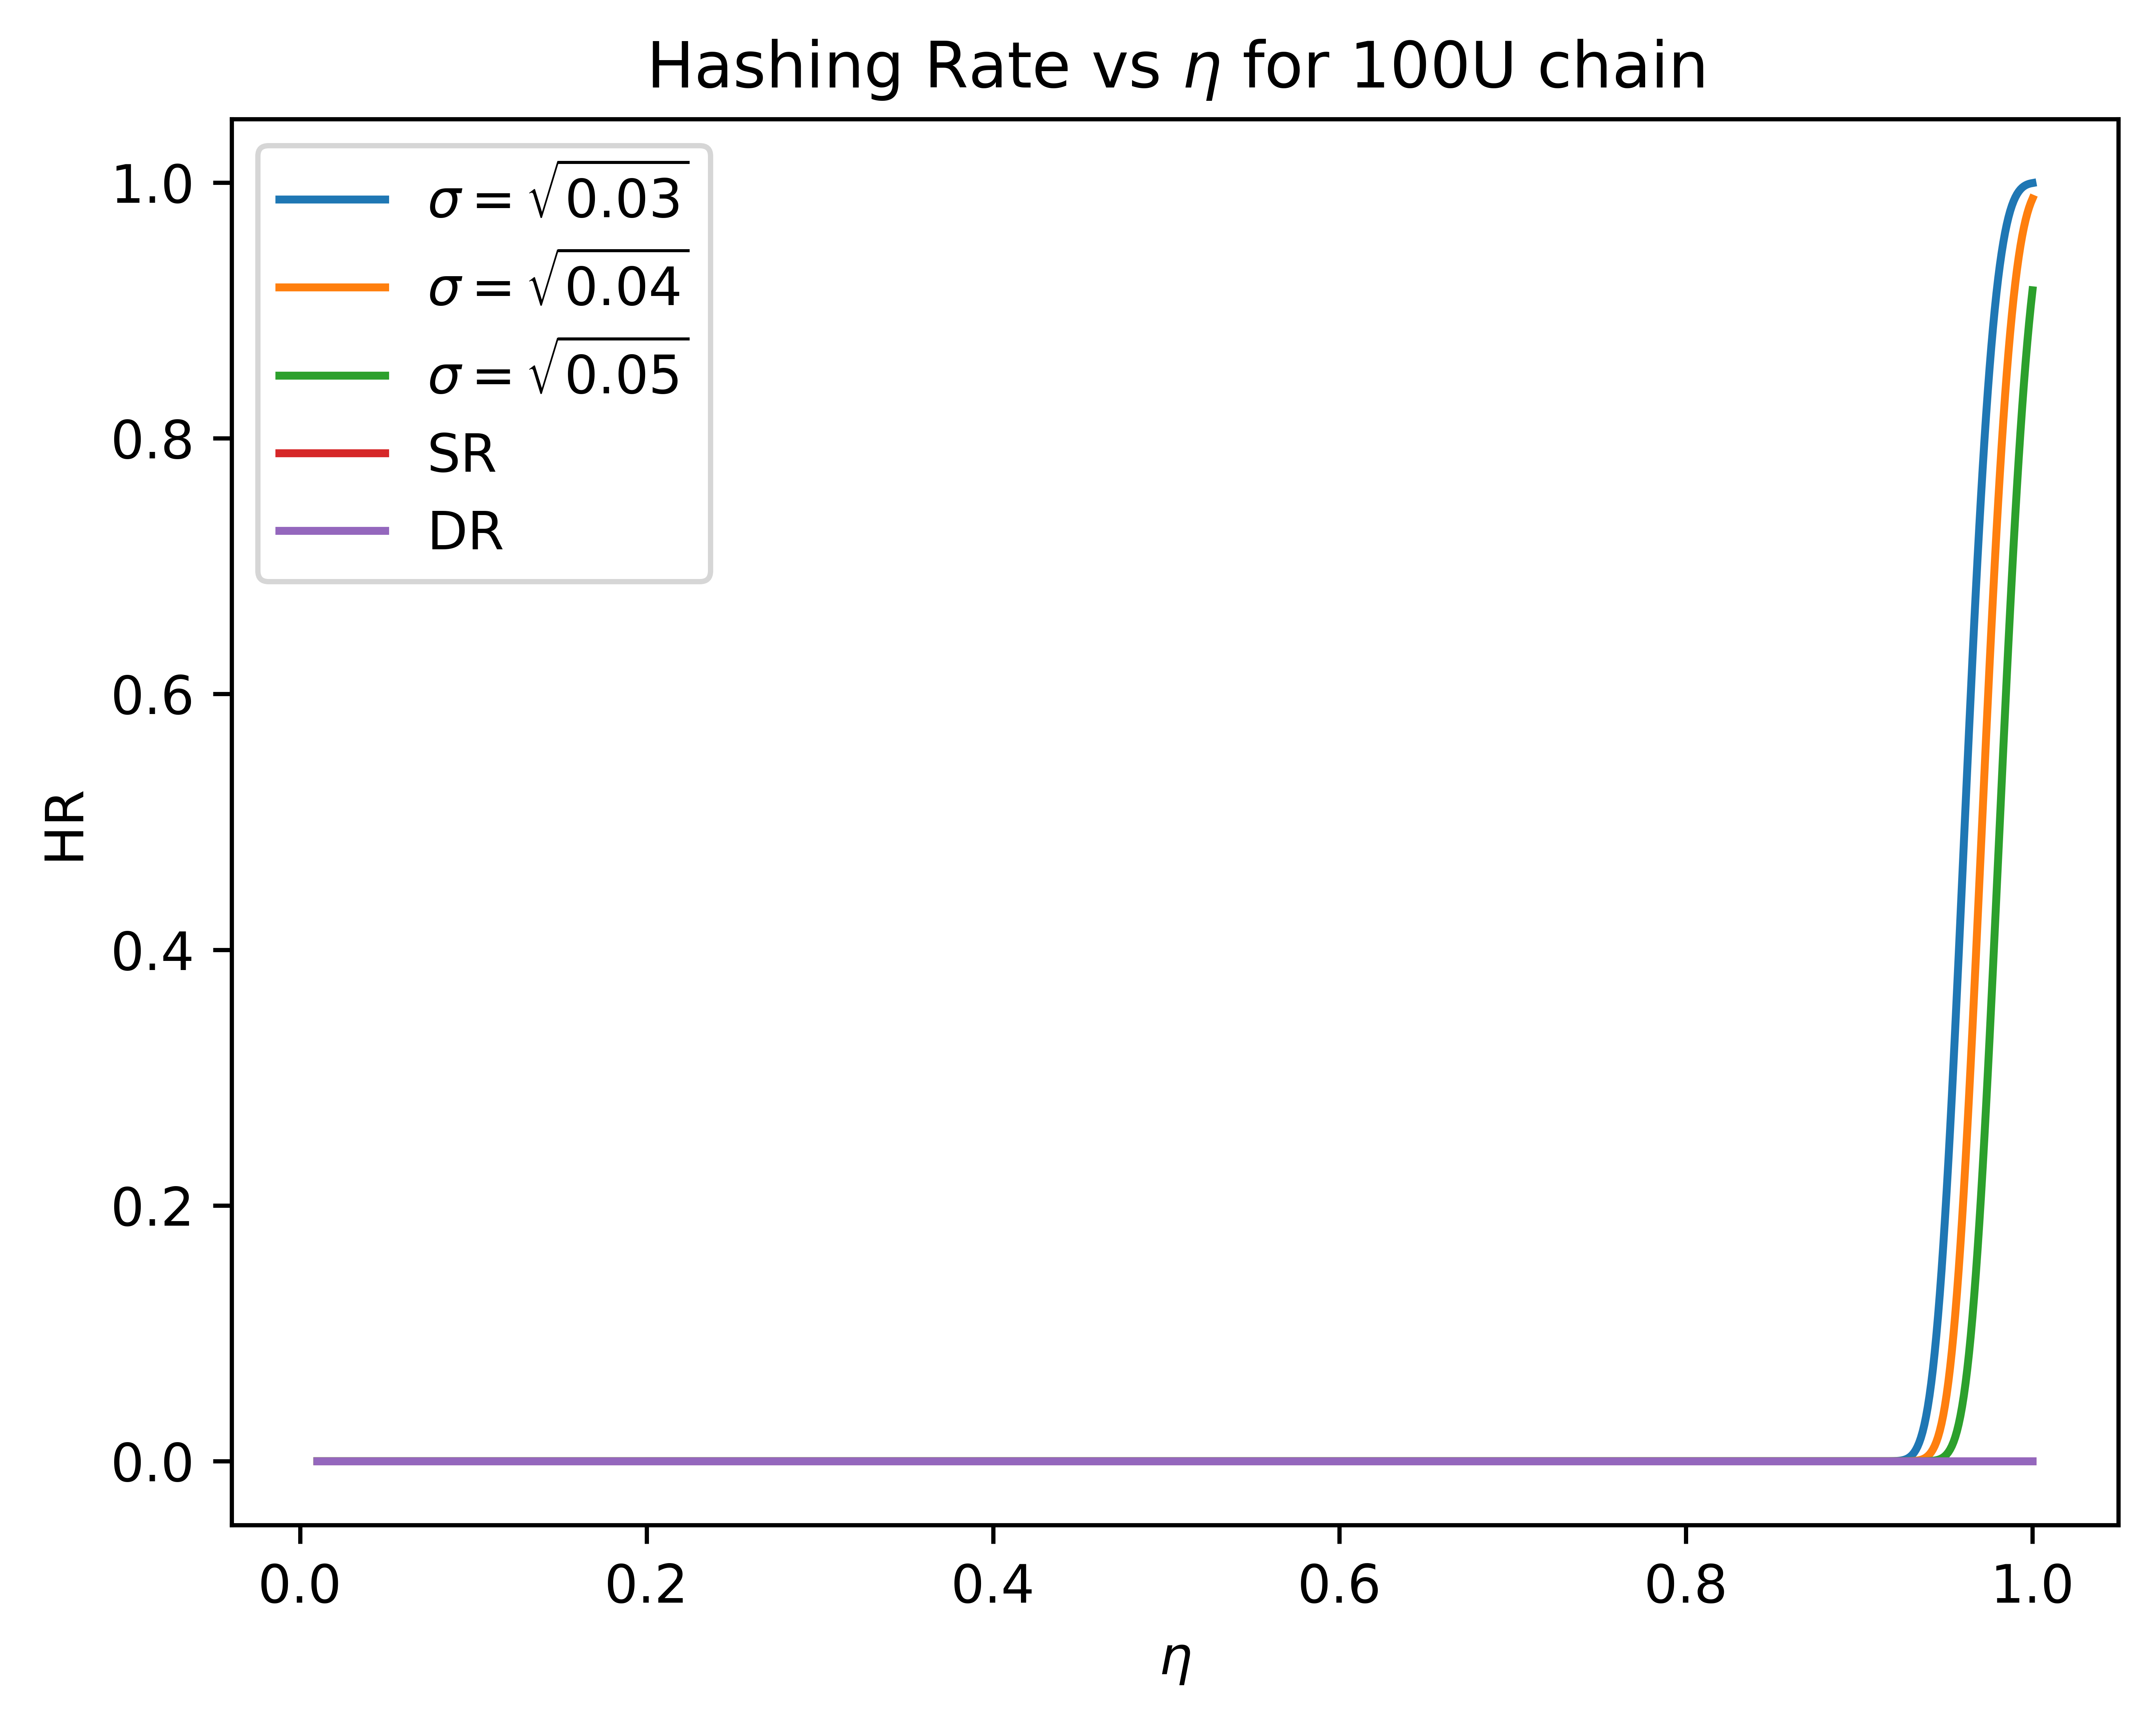

In [14]:
# Results

sigma1 = np.sqrt(0.03)
sigma2 = np.sqrt(0.04)
sigma3 = np.sqrt(0.05)

n = 100

etas = np.linspace(0.01 , 1.0 , 1000)

rates1 = [optimal_hashing_rate(sigma1 , eta , n) for eta in etas]
rates2 = [optimal_hashing_rate(sigma2 , eta , n) for eta in etas]
rates3 = [optimal_hashing_rate(sigma3 , eta , n) for eta in etas]

ratesSR = [optimal_SRhashingrate(eta , n) for eta in etas]
ratesDR = [DRhashingrate(eta , n) for eta in etas]


plt.figure(dpi = 1000)
plt.plot(etas , rates1 , label = r"$\sigma = \sqrt{0.03}$")
plt.plot(etas , rates2 , label = r"$\sigma = \sqrt{0.04}$")
plt.plot(etas , rates3 , label = r"$\sigma = \sqrt{0.05}$")
plt.plot(etas , ratesSR , label = r"SR")
plt.plot(etas , ratesDR , label = r"DR")
plt.xlabel("$\eta$")
plt.ylabel("HR")
plt.title(f"Hashing Rate vs $\eta$ for 100U chain")
plt.legend()
plt.show()